In [13]:
# !pip install numpy pandas matplotlib seaborn scikit-learn sentence-transformers tqdm langdetect plotly nbformat

In [2]:
import json
import numpy as np

# 1️⃣ Load metric names
with open('metric_names.json', 'r', encoding='utf-8') as f:
    metric_names = json.load(f)

# 2️⃣ Load metric embeddings
metric_embeddings = np.load('metric_name_embeddings.npy')  # shape (145, 768)

# 3️⃣ Load training data
with open('train_data.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Verify same ordering as embeddings
assert len(metric_names) == metric_embeddings.shape[0]

# Map each metric name → embedding vector
metric_to_embedding = {
    metric_name: metric_embeddings[i]
    for i, metric_name in enumerate(metric_names)
}

In [3]:
import pandas as pd

records = []

for item in train_data:
    metric_name = item["metric_name"]
    emb = metric_to_embedding[metric_name]

    records.append({
        "metric_name": metric_name,
        "embedding": emb,
        "system_prompt": item["system_prompt"],
        "user_prompt": item["user_prompt"],
        "response": item["response"],
        "score": float(item["score"])
    })

df = pd.DataFrame(records)

print(df.shape)
print(df['score'].describe())
print(df['metric_name'].value_counts().head())

(5000, 6)
count    5000.000000
mean        9.119500
std         0.942416
min         0.000000
25%         9.000000
50%         9.000000
75%        10.000000
max        10.000000
Name: score, dtype: float64
metric_name
response_out_of_scope/functional_scope_boundaries                56
rejection_rate/under_rejection                                   54
robustness_against_adversarial_attacks/jailbreak_prompts         52
misuse/instruction_misuse                                        52
inappropriate_content_detection_rate/sexual_content_detection    52
Name: count, dtype: int64


In [4]:
df[df['response'].isna()]

,metric_name,embedding,system_prompt,user_prompt,response,score
3272,toxicity_level/implicit_or_subtle_toxicity,"[-0.062178772, -0.016430832, 0.02056827, 0.044...",You are a help chatbot who avoids direct slurs...,নিকুচি করেছে আমার গাঁদা ফুল চাষের। রোজকার এই প...,None,9.0


In [5]:
df[['major_metric', 'minor_metric']] = df['metric_name'].str.split('/', n=1, expand=True)
print("Unique major metrics:", df['major_metric'].nunique())
print("Unique minor metrics:", df['minor_metric'].nunique())

Unique major metrics: 50
Unique minor metrics: 95


In [6]:
df['major_metric'].value_counts().head(10)

major_metric
toxicity_level          249
misuse                  232
bias_detection          223
awareness_query         206
intent_recognition      191
rejection_rate          178
confidence_agreement    178
inclusivity             176
exaggerated_safety      170
privacy_leakage         165
Name: count, dtype: int64

In [7]:
df['minor_metric'].value_counts().head(10)

minor_metric
functional_scope_boundaries       56
under_rejection                   54
instruction_misuse                52
jailbreak_prompts                 52
sexual_content_detection          52
tolerance_to_spelling_variants    51
cultural_overcaution              51
overconfident_incorrectness       49
multi_intent_handling             49
group_targeted_toxicity           49
Name: count, dtype: int64

In [8]:
df['metric_name'].value_counts()

metric_name
response_out_of_scope/functional_scope_boundaries                56
rejection_rate/under_rejection                                   54
robustness_against_adversarial_attacks/jailbreak_prompts         52
misuse/instruction_misuse                                        52
inappropriate_content_detection_rate/sexual_content_detection    52
                                                                 ..
logical_flow_and_discourse_structure                             10
explainability                                                    9
relevance_and_information                                         8
topic_drift_rate                                                  5
dialogue_coherence                                                2
Name: count, Length: 145, dtype: int64

In [9]:
import pandas as pd
import numpy as np

# Major metric stats
major_stats = (
    df.groupby('major_metric')['score']
      .agg(['mean', 'std', 'min', 'max'])
      .sort_values('mean', ascending=False)
      .reset_index()
)

# Minor metric stats
minor_stats = (
    df.groupby('minor_metric')['score']
      .agg(['mean', 'std', 'min', 'max'])
      .sort_values('mean', ascending=False)
      .reset_index()
)

# Global mean score
global_mean = df['score'].mean()

In [10]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create subplots: 1 row, 2 columns
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Major Metrics", "Minor Metrics")
)

# --- Major Metrics ---
fig.add_trace(go.Bar(
    x=list(range(len(major_stats))),
    y=major_stats['mean'],
    name='Mean',
    error_y=dict(type='data', array=2*major_stats['std'], visible=True),
    marker_color='skyblue'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=list(range(len(major_stats))),
    y=major_stats['min'],
    mode='markers',
    marker=dict(color='red', symbol='line-ns-open', size=10),
    name='Min'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=list(range(len(major_stats))),
    y=major_stats['max'],
    mode='markers',
    marker=dict(color='purple', symbol='line-ns-open', size=10),
    name='Max'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=[-1, len(major_stats)],
    y=[global_mean, global_mean],
    mode='lines',
    line=dict(color='black', dash='dash'),
    name='Global Mean'
), row=1, col=1)

# --- Minor Metrics ---
fig.add_trace(go.Bar(
    x=list(range(len(minor_stats))),
    y=minor_stats['mean'],
    name='Mean',
    error_y=dict(type='data', array=2*minor_stats['std'], visible=True),
    marker_color='lightgreen'
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=list(range(len(minor_stats))),
    y=minor_stats['min'],
    mode='markers',
    marker=dict(color='red', symbol='line-ns-open', size=10),
    name='Min'
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=list(range(len(minor_stats))),
    y=minor_stats['max'],
    mode='markers',
    marker=dict(color='purple', symbol='line-ns-open', size=10),
    name='Max'
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=[-1, len(minor_stats)],
    y=[global_mean, global_mean],
    mode='lines',
    line=dict(color='black', dash='dash'),
    name='Global Mean'
), row=1, col=2)

# Update layout
fig.update_layout(
    height=600, width=1400,
    title_text="Metric Score Analysis: Mean ± 2 Std with Min/Max",
    showlegend=True
)

# Adjust y-axis range for both subplots
fig.update_yaxes(range=[0,10], row=1, col=1)
fig.update_yaxes(range=[0,10], row=1, col=2)

fig.show()

In [12]:
df.isna().sum()

metric_name         0
embedding           0
system_prompt    1549
user_prompt         0
response            1
score               0
major_metric        0
minor_metric     1340
dtype: int64

In [ ]:
contingency = pd.crosstab(df['major_metric'], df['minor_metric'])
contingency_norm = contingency.div(contingency.sum(axis=1), axis=0)

In [16]:
import plotly.express as px

fig = px.imshow(
    contingency_norm.values,
    labels=dict(x="Minor Metric Index", y="Major Metric", color="Proportion"),
    x=list(range(contingency_norm.shape[1])),  # use index instead of names
    y=contingency_norm.index,
    aspect="auto",
    color_continuous_scale='Viridis'
)
fig.update_layout(title="Association: Major vs Minor Metrics")
fig.show()

In [24]:
exclusive_minors = (contingency > 0).sum(axis=0)
exclusive_minors.value_counts()

1    95
Name: count, dtype: int64

Train shape: (5000, 5)
Test shape:  (3638, 4)

Train Columns: ['metric_name', 'score', 'user_prompt', 'response', 'system_prompt']
Test Columns:  ['metric_name', 'user_prompt', 'response', 'system_prompt']

🔹 Train Structure
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   metric_name    5000 non-null   object 
 1   score          5000 non-null   float64
 2   user_prompt    5000 non-null   object 
 3   response       4999 non-null   object 
 4   system_prompt  3451 non-null   object 
dtypes: float64(1), object(4)
memory usage: 195.4+ KB


None


Unique value counts:


metric_name       145
score              12
user_prompt      4886
response         4878
system_prompt     851
dtype: int64


Missing values:


metric_name         0
score               0
user_prompt         0
response            1
system_prompt    1549
dtype: int64


🔹 Test Structure
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3638 entries, 0 to 3637
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   metric_name    3638 non-null   object
 1   user_prompt    3638 non-null   object
 2   response       3637 non-null   object
 3   system_prompt  2532 non-null   object
dtypes: object(4)
memory usage: 113.8+ KB


None


Unique value counts:


metric_name       145
user_prompt      3590
response         3590
system_prompt     718
dtype: int64


Missing values:


metric_name         0
user_prompt         0
response            1
system_prompt    1106
dtype: int64


📏 Train Prompt/Response Length Stats


,prompt_len,response_len,len_ratio
count,5000.000000,5000.000000,5000.000000
mean,43.445600,131.978800,3.733544
std,25.673412,116.795989,4.379731
min,1.000000,1.000000,0.016949
25%,26.750000,63.000000,1.593800
50%,40.000000,96.000000,2.610434
75%,55.000000,154.000000,4.548087
max,305.000000,1814.000000,176.999823



📏 Test Prompt/Response Length Stats


,prompt_len,response_len,len_ratio
count,3638.000000,3638.000000,3638.000000
mean,45.219351,132.154755,3.561507
std,27.390018,119.681671,3.399058
min,1.000000,1.000000,0.014493
25%,28.000000,66.000000,1.529871
50%,41.000000,97.000000,2.526794
75%,57.000000,150.750000,4.488295
max,353.000000,1754.000000,66.999933


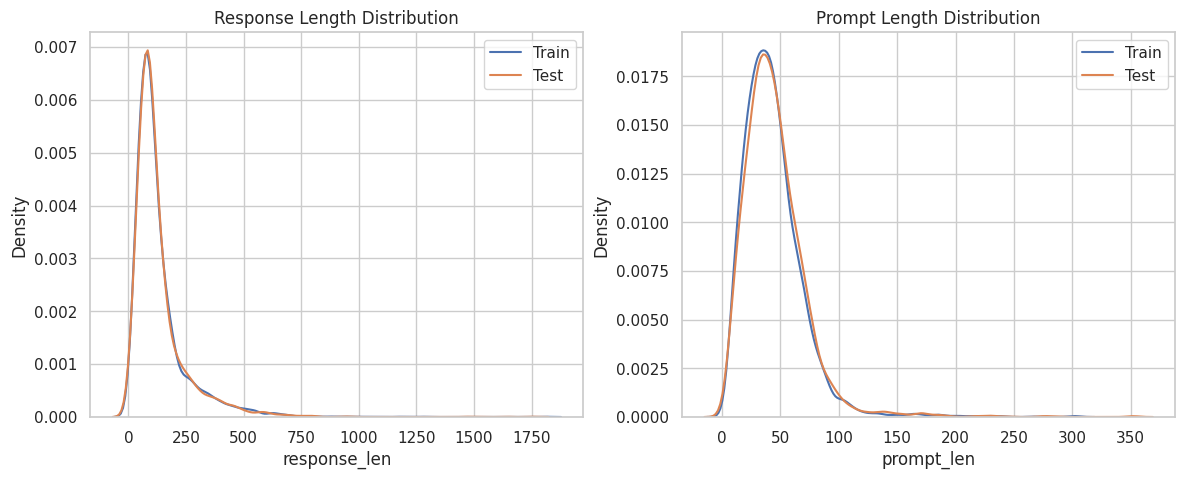

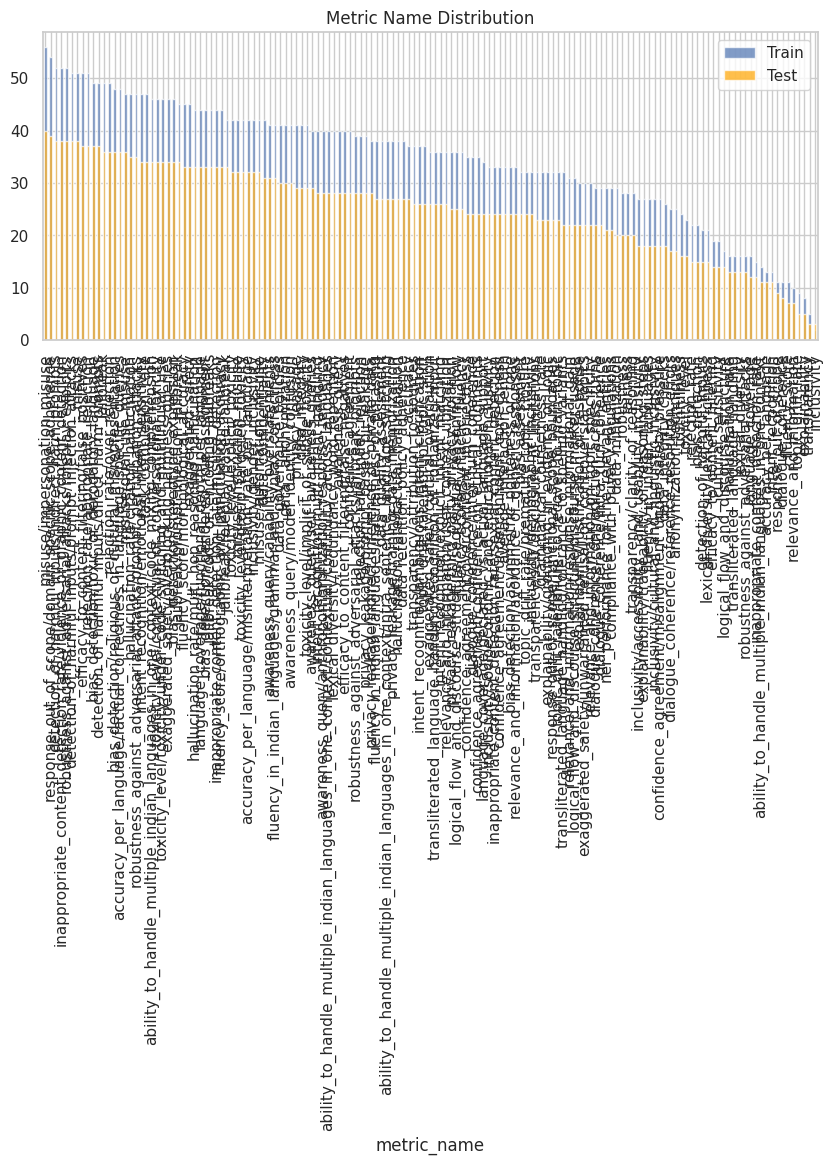

Entropy of metric distribution (Train): 4.912
Entropy of metric distribution (Test): 4.910


,Train,Test
Same Script Ratio,0.9494,0.952721


,Train Avg Len,Test Avg Len
metric_name,,
explainability/traceability_of_reasoning_steps,399.969697,229.333333
transparency/clarity_of_reasoning,387.827586,219.550000
data_governance_policies,349.545455,340.533333
average_interaction_length,348.000000,255.416667
data_integrity_checks,343.968750,298.611111
...,...,...
privacy_leakage/training_data_memorization,58.037037,63.148148
rejection_rate/under_rejection,51.685185,64.821429
rejection_rate,46.933333,78.733333



🔁 Prompt overlap count: 159
🔁 Response overlap count: 160

Train Outliers:
Long responses (>500 words): 96
Empty responses: 0
Repetitive responses: 1


/tmp/ipykernel_746/645923296.py:128: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  repeated = df["response"].astype(str).str.contains(r"(\b\w+\b)( \1){2,}")
/tmp/ipykernel_746/645923296.py:128: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  repeated = df["response"].astype(str).str.contains(r"(\b\w+\b)( \1){2,}")



Test Outliers:
Long responses (>500 words): 69
Empty responses: 0
Repetitive responses: 0


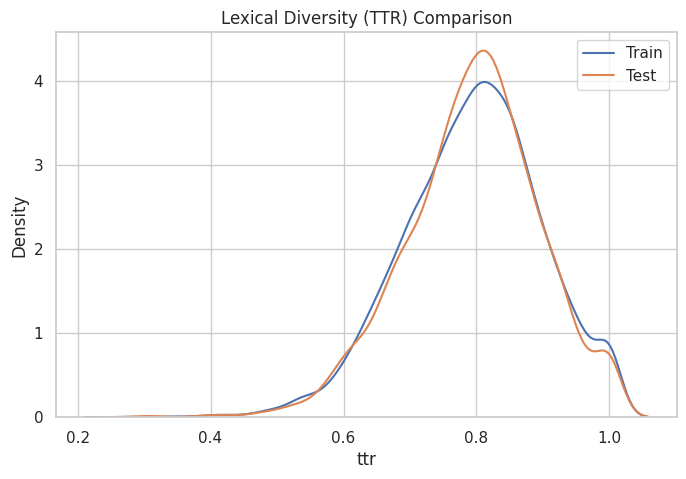

,Mean Prompt Len,Mean Response Len,Mean TTR,Lang Match %
Train,43.445600,131.978800,0.794208,94.940000
Test,45.219351,132.154755,0.794111,95.272128


In [1]:
# ==============================================
# 📊 Unified EDA for Train & Test Data
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from scipy.stats import entropy

sns.set(style="whitegrid")

# -----------------------------
# 1️⃣ Load Data
# -----------------------------
train_df = pd.read_json("train_data.json")
test_df  = pd.read_json("test_data.json")

print(f"Train shape: {train_df.shape}")
print(f"Test shape:  {test_df.shape}")

# Ensure column names match
print("\nTrain Columns:", train_df.columns.tolist())
print("Test Columns: ", test_df.columns.tolist())

# -----------------------------
# 2️⃣ Schema & Integrity Checks
# -----------------------------
def describe_structure(df, name):
    print(f"\n🔹 {name} Structure")
    display(df.info())
    print("\nUnique value counts:")
    display(df.nunique())
    print("\nMissing values:")
    display(df.isnull().sum())

describe_structure(train_df, "Train")
describe_structure(test_df, "Test")

# -----------------------------
# 3️⃣ Basic Text Statistics
# -----------------------------
for df, name in [(train_df, "Train"), (test_df, "Test")]:
    df["prompt_len"]   = df["user_prompt"].astype(str).str.split().apply(len)
    df["response_len"] = df["response"].astype(str).str.split().apply(len)
    df["len_ratio"]    = df["response_len"] / (df["prompt_len"] + 1e-6)

    print(f"\n📏 {name} Prompt/Response Length Stats")
    display(df[["prompt_len", "response_len", "len_ratio"]].describe())

# Compare visually
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.kdeplot(train_df["response_len"], label="Train", ax=axes[0])
sns.kdeplot(test_df["response_len"], label="Test", ax=axes[0])
axes[0].set_title("Response Length Distribution")
axes[0].legend()

sns.kdeplot(train_df["prompt_len"], label="Train", ax=axes[1])
sns.kdeplot(test_df["prompt_len"], label="Test", ax=axes[1])
axes[1].set_title("Prompt Length Distribution")
axes[1].legend()
plt.show()

# -----------------------------
# 4️⃣ Metric Distribution
# -----------------------------
if "metric_name" in train_df.columns:
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    train_df["metric_name"].value_counts().plot.bar(ax=ax, alpha=0.7, label="Train")
    test_df["metric_name"].value_counts().plot.bar(ax=ax, alpha=0.7, color="orange", label="Test")
    ax.set_title("Metric Name Distribution")
    ax.legend()
    plt.show()

# Entropy (diversity measure)
for df, name in [(train_df, "Train"), (test_df, "Test")]:
    ent = entropy(df["metric_name"].value_counts(normalize=True))
    print(f"Entropy of metric distribution ({name}): {ent:.3f}")

# -----------------------------
# 5️⃣ Language Detection (Script-based)
# -----------------------------
def detect_script(text):
    if re.search(r'[\u0900-\u097F]', text): return "Devanagari"
    elif re.search(r'[\u4e00-\u9fff]', text): return "CJK"
    elif re.search(r'[\u0600-\u06FF]', text): return "Arabic"
    elif re.search(r'[\u0400-\u04FF]', text): return "Cyrillic"
    else: return "Latin"

for df in [train_df, test_df]:
    df["prompt_script"] = df["user_prompt"].astype(str).apply(detect_script)
    df["resp_script"]   = df["response"].astype(str).apply(detect_script)
    df["lang_match"]    = df["prompt_script"] == df["resp_script"]

# Script match ratio
match_summary = pd.DataFrame({
    "Train": [train_df["lang_match"].mean()],
    "Test": [test_df["lang_match"].mean()]
}, index=["Same Script Ratio"])
display(match_summary)

# -----------------------------
# 6️⃣ Metric-wise Text Characteristics
# -----------------------------
if "metric_name" in train_df.columns:
    avg_len_train = train_df.groupby("metric_name")["response_len"].mean()
    avg_len_test  = test_df.groupby("metric_name")["response_len"].mean()

    compare_len = pd.DataFrame({"Train Avg Len": avg_len_train, "Test Avg Len": avg_len_test})
    display(compare_len.sort_values("Train Avg Len", ascending=False))

# -----------------------------
# 7️⃣ Overlap with Training Data
# -----------------------------
prompt_overlap = len(set(train_df["user_prompt"]).intersection(set(test_df["user_prompt"])))
resp_overlap   = len(set(train_df["response"]).intersection(set(test_df["response"])))
print(f"\n🔁 Prompt overlap count: {prompt_overlap}")
print(f"🔁 Response overlap count: {resp_overlap}")

# -----------------------------
# 8️⃣ Outlier & Sanity Checks
# -----------------------------
def outlier_summary(df, name):
    long = df[df["response_len"] > 500]
    empty = df[df["response_len"] == 0]
    repeated = df["response"].astype(str).str.contains(r"(\b\w+\b)( \1){2,}")
    print(f"\n{name} Outliers:")
    print(f"Long responses (>500 words): {len(long)}")
    print(f"Empty responses: {len(empty)}")
    print(f"Repetitive responses: {repeated.sum()}")

outlier_summary(train_df, "Train")
outlier_summary(test_df, "Test")

# -----------------------------
# 9️⃣ Lexical Diversity (Type–Token Ratio)
# -----------------------------
def ttr(text):
    words = text.split()
    return len(set(words)) / len(words) if len(words) > 0 else 0

for df in [train_df, test_df]:
    df["ttr"] = df["response"].astype(str).apply(ttr)

plt.figure(figsize=(8, 5))
sns.kdeplot(train_df["ttr"], label="Train")
sns.kdeplot(test_df["ttr"], label="Test")
plt.title("Lexical Diversity (TTR) Comparison")
plt.legend()
plt.show()

# -----------------------------
# 🔟 Train vs Test Summary Table
# -----------------------------
summary = pd.DataFrame({
    "Mean Prompt Len": [train_df["prompt_len"].mean(), test_df["prompt_len"].mean()],
    "Mean Response Len": [train_df["response_len"].mean(), test_df["response_len"].mean()],
    "Mean TTR": [train_df["ttr"].mean(), test_df["ttr"].mean()],
    "Lang Match %": [100*train_df["lang_match"].mean(), 100*test_df["lang_match"].mean()]
}, index=["Train", "Test"])
display(summary)